In [1]:
import os
# set the appropriate path to whichever R installation we'd like to use
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
from fnc_analysis import *
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from pathlib import Path
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
%%R
library(lme4)
library(lmerTest)
library(splines)
library(rstatix)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: 
Attaching package: ‘rstatix’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




In [3]:
# figure settings
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.size']= 8


fig_save_loc = Path('figures')
stat_save_loc = Path('stats/raw')
os.makedirs(fig_save_loc/'pdfs', exist_ok=True) 
os.makedirs(fig_save_loc/'svgs', exist_ok=True) 
os.makedirs(stat_save_loc, exist_ok=True) 
ctl_col = '#D4D4D4'
stim_col = '#06e1e9'

In [4]:
# load tidy data and subset dataframes for later use
data_dir = "../../data/behavior"

#load unlimited intake
df = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/total_licks_normal_intake.csv'))
dft = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/lick_times_normal_intake.csv'))

#load limited intake
df_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/total_licks_limited_intake.csv'))
dft_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/lick_times_limited_intake.csv'))

#load extinction
df_ex = load_data(os.path.join(data_dir,'pre_processed/extinction3/total_licks_extinction3.csv'))
dft_ex = load_data(os.path.join(data_dir,'pre_processed/extinction3/lick_times_extinction3.csv'))

#load extinction pt2
df_ex2 = load_data(os.path.join(data_dir,'pre_processed/extinction4/total_licks_extinction4.csv'))
dft_ex2 = load_data(os.path.join(data_dir,'pre_processed/extinction4/lick_times_extinction4.csv'))


#select glucose data
#unlimited intake
df_test_g = subset_df(df, 'glucose', 'test')
dft_test_g = subset_df(dft, 'glucose', 'test')

df_train_g = subset_df(df, 'glucose', 'training')
dft_train_g = subset_df(dft, 'glucose', 'training')


#limited intake
df_test_g_ltd = subset_df(df_ltd, 'glucose', 'test')
dft_test_g_ltd = subset_df(dft_ltd, 'glucose', 'test')

df_train_g_ltd = subset_df(df_ltd, 'glucose', 'training')
dft_train_g_ltd = subset_df(dft_ltd, 'glucose', 'training')


#extinction
df_test_g_ex = subset_df(df_ex, 'glucose', 'test') 
dft_test_g_ex = subset_df(dft_ex, 'glucose', 'test') 

df_train_g_ex = subset_df(df_ex, 'glucose', 'training') 
dft_train_g_ex = subset_df(dft_ex, 'glucose', 'training') 

#extinction 2
df_test_g_ex2 = subset_df(df_ex2, 'glucose', 'test')
dft_test_g_ex2 = subset_df(dft_ex2, 'glucose', 'test')

df_train_g_ex2 = subset_df(df_ex2, 'glucose', 'training')
dft_train_g_ex2 = subset_df(dft_ex2, 'glucose', 'training')

#combine
df_test_g_ltd_cohort = pd.concat({0: df_test_g_ltd, 
                                  1: df_test_g_ex.loc[:,:,:1], 
                                  2: df_test_g_ex2.loc[:,:,:1]}, 
                                 names=['cohort'])
df_test_g_ltd = df_test_g_ltd_cohort.droplevel('cohort').sort_index()

dft_test_g_ltd_cohort = pd.concat({0: dft_test_g_ltd, 
                                   1: dft_test_g_ex.loc[:,:,:1], 
                                   2: dft_test_g_ex2.loc[:,:,:1]}, 
                                  names=['cohort'])
dft_test_g_ltd = dft_test_g_ltd_cohort.droplevel('cohort')


df_train_g_ltd_cohort = pd.concat({0: df_train_g_ltd, 
                                   1: df_train_g_ex, 
                                   2: df_train_g_ex2}, 
                                  names=['cohort'])
df_train_g_ltd = df_train_g_ltd_cohort.droplevel('cohort')


dft_train_g_ltd_cohort = pd.concat({0: dft_train_g_ltd, 
                                    1: dft_train_g_ex, 
                                    2: dft_train_g_ex2}, 
                                   names=['cohort'])
dft_train_g_ltd = dft_train_g_ltd_cohort.droplevel('cohort').sort_index()

## Lickometer Validation

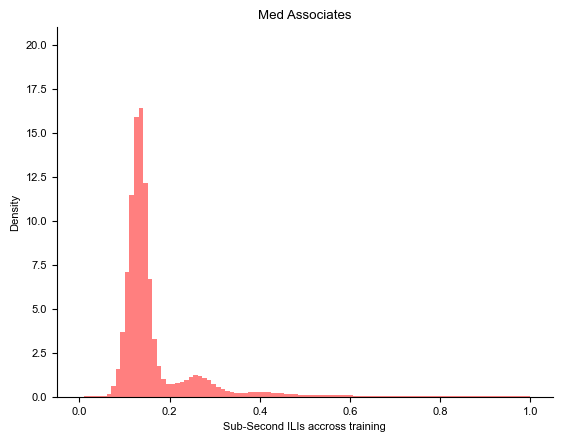

In [5]:
#compute ilis
ilis = dft_train_g.time.groupby(['mouse','day','CS']).apply(lambda x: (x.iloc[1:] - x.iloc[:-1]).reset_index(drop=True))
subs = ilis.loc[ilis<1]
bins = np.linspace(0,1, 100)
plt.hist(subs,bins, alpha = 0.5, density = True, color='r');
plt.xlabel('Sub-Second ILIs accross training')
plt.ylabel('Density')
plt.title('Med Associates')
plt.ylim(0,21)
sns.despine()
plt.savefig('figures/pdfs/ili_resolutin_benchmark_med.pdf')
plt.savefig('figures/svgs/ili_resolutin_benchmark_med.svg')

## Figure 1 - unlimited intake, food deprived

In [6]:
#@title general stats
print("Glucose:")
print("Controls: n = ", df_test_g.loc[False,].index.get_level_values('mouse').unique().size)
print("Stim: n = ",     df_test_g.loc[True, ].index.get_level_values('mouse').unique().size)

Glucose:
Controls: n =  15
Stim: n =  14


### schematic

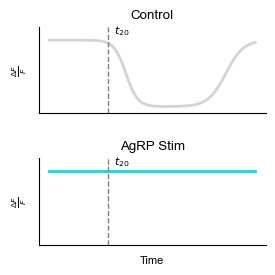

In [7]:
from scipy.special import expit
x = np.linspace(-10,25,100)
fig, ax = plt.subplots(2,1, figsize = (3,3))
ax[0].plot(x, -expit(x-3) + expit((x-20)/1.5), c = ctl_col, lw = 2)
ax[0].axvline(0, ls = '--', c = 'gray', lw = 1)
ax[0].text(1,0.1,r'$t_{20}$')

ax[0].set(ylim = (-1.1,.2),
          xticks = [], yticks = [],
          ylabel = r'$\frac{\Delta F}{F}$',
          title = "Control")
ax[1].plot(x, [0]*x.size,  c= stim_col, lw = 2)
ax[1].axvline(0, ls = '--', c = 'gray', lw = 1)
ax[1].text(1,0.1,r'$t_{20}$')

ax[1].set(ylim = ax[0].get_ylim(),
          xticks = [], yticks = [],
          xlabel = 'Time', 
          ylabel = r'$\frac{\Delta F}{F}$',
          title = "AgRP Stim")

sns.despine()
fig.tight_layout(pad = 2.)
fig.savefig(fig_save_loc/'pdfs'/'fig1_schematic.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig1_schematic.svg', transparent=True, bbox_inches='tight')

### validating feeding for normal intake cohort

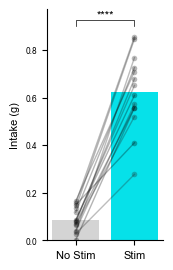

In [8]:
normal_intake = (pd.read_csv(os.path.join(data_dir,"raw_data/normal_intake/opto_validation.csv"), index_col = 0)
                   .stack()
                   .reset_index()
                   .rename(columns = {'Mouse ': 'mouse', 
                                      "level_1": 'stim', 
                                      0:'intake'})
                   .set_index('mouse')
                   .loc[df_test_g.loc[True,].index.get_level_values('mouse').unique()]
                   .reset_index()
                )

_,ax = plt.subplots(1,1, figsize = (1.5,3))
sns.barplot(data=normal_intake, x = 'stim', y = 'intake', saturation = 1,
            errorbar = None, palette = [ctl_col, stim_col], ax = ax)
sns.lineplot(normal_intake, x='stim', y='intake', hue='mouse', palette='dark:k', 
             alpha=0.3, marker = 'o', markeredgewidth=0, legend=False, lw=1, ms=4)

normal_intake = normal_intake.set_index(['mouse','stim']).intake.unstack('stim')
fint_stat = st.ttest_rel(normal_intake['no_stim '], normal_intake['stim'])

plot_significance(fint_stat[1], ax=ax,x1=0,x2=1,yy=0.9, h=.025)

for j in ax.get_yticklabels():
    j.set_fontsize(6)

sns.despine()
plt.ylabel("Intake (g)")
plt.xticks([0,1], ['No Stim', 'Stim'])
plt.xlabel("")
plt.savefig("figures/svgs/fig1_opto_feeding_val.svg")
plt.savefig("figures/pdfs/fig1_opto_feeding_val.pdf")

#### stats

In [9]:
fig1_stats = {}

In [10]:
fint_stat = pd.Series(list(fint_stat) + [fint_stat.df], index = ('t', 'p-value', 'df')).rename('t-test').to_frame().T
fint_stat['Significance'] = fint_stat['p-value'].apply(check_significance)
display(fint_stat)

fig1_stats.update({"c_stim_food_intake_stats": fint_stat})

,t,p-value,df,Significance
t-test,-13.856584,3.656564e-09,13.0,****


### main plots

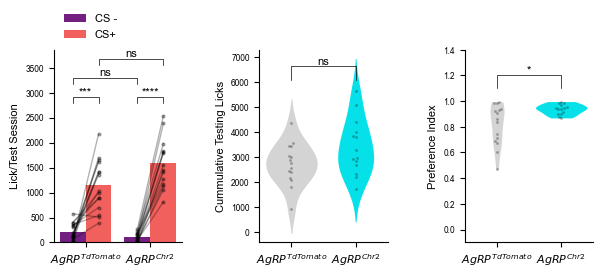

In [11]:
# create the subplot
fig, ax = plt.subplots(1,3, figsize=(6.5,3.25))

# get the average stim and control testing licks for CS+ vs CS- flavors
normal_stim = average_test_data(df_test_g, Chr2=True)
normal_ctl = average_test_data(df_test_g, Chr2=False)

# plot average cs+ and cs- licks during testing
_, stats_g = two_bottle_plot(normal_stim, normal_ctl, ax=ax[0], ms=2, lw=1)


# plot total testing licks
_, stats_g_tot = cumm_test_licks_plot(df_test_g.loc[True,],df_test_g.loc[False,],
                                      palette = [stim_col, ctl_col], ax = ax[1], ms=2)

# plot the preference indices
_, pref_g, p_pref = two_bottle_pref_plot_vl(df_test_g.loc[True,], df_test_g.loc[False,] , 
                                            ax=ax[2], palette = [stim_col, ctl_col], ms=2);

# ensure the limits on the y-axes are all the same
for i in range(3):
    for j in ax[i].get_yticklabels():
        j.set_fontsize(6)

fig.tight_layout(pad=3)

#save the figure
fig.savefig(fig_save_loc/'pdfs'/'fig1_plots.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig1_plots.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - glucose unlimited intake mean total licks during testing stats
We will use a Mixed ANOVA to characterize the lick data followed by pairwise t-tests.

In [12]:
df = df_test_g.groupby(['Chr2','mouse','CS']).mean(numeric_only=True).reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
test_anova_g = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', 
                              dv = 'total_licks', subject = 'mouse')
test_anova_g = test_anova_g.rename(columns = {'p-unc': 'p-value'})
test_anova_g['Significance'] = test_anova_g['p-value'].apply(check_significance)
stats_g = stats_g.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_g['Significance'] = stats_g['Corrected p-value'].apply(check_significance)

display(shapiro, levene, test_anova_g , stats_g)
fig1_stats.update({'e_test_anova_g'   : test_anova_g ,
                   'e_test_posthoc_g' : stats_g})

statistic   p-value
Chr2  CS                     
False +    0.960600  0.702824
      -    0.911952  0.145072
True  +    0.962844  0.769512
      -    0.941924  0.443534

,statistic,p-value
CS,,
+,0.059609,0.808960
-,4.216178,0.049844


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,4.224532e+05,1,27,4.224532e+05,3.505980,7.201558e-02,0.114928,NaN,ns
1,CS,2.068247e+07,1,27,2.068247e+07,132.517874,6.382438e-12,0.830740,1.0,****
2,Interaction,1.041430e+06,1,27,1.041430e+06,6.672708,1.552742e-02,0.198164,NaN,*


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,12.274082,1.593141e-08,6.372564e-08,13,True,****
CS+ vs. CS- $AgRP^{TdTomato}$,5.623017,6.284688e-05,1.885288e-04,14,True,***
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,2.327569,2.769079e-02,5.461479e-02,27,False,ns
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,-1.969110,6.255176e-02,6.255176e-02,27,False,ns


##### stats - stim v control cummulative test licks comparison

In [13]:
res_g = pd.DataFrame({"t": [stats_g_tot[0]], 
                      "df": [stats_g_tot[2]],
                      "p-value": [stats_g_tot[1]], 
                      "Significance": check_significance(stats_g_tot[1])
                     }, index = ['ttest'])
print("glucose")
display(res_g)
fig1_stats.update({"f_ttest_stim_v_ctl_tot_g": res_g})

glucose


,t,df,p-value,Significance
ttest,1.853312,27,0.076186,ns


##### stats - stim v control pref comparison

In [14]:
res_g = pd.DataFrame({"U": [p_pref[0]], 
                      "p-value": [p_pref[1]],
                      "Significance": check_significance(p_pref[1])
                     }, index = ['mann whitney u test'])

print("glucose")
display(res_g)

fig1_stats.update({"g_rank_sum_stim_v_ctl_pref_g": res_g})

glucose


,U,p-value,Significance
mann whitney u test,152.0,0.042415,*


In [15]:
with pd.ExcelWriter(stat_save_loc/'figure1.xlsx') as writer:  
    for k,v in fig1_stats.items():
        v.to_excel(writer, sheet_name=k)

## Supplemental Figure 1 - cummulative training licks

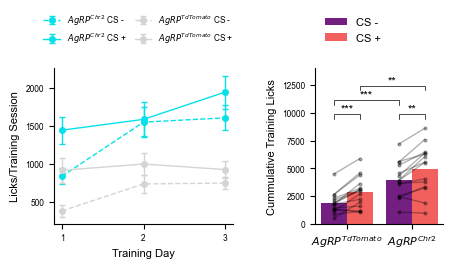

In [16]:
# get cummulative training licks for stim and control mice
cumm = df_train_g.total_licks.groupby(['Chr2','mouse','CS']).sum()
sg = cumm.loc[True,].to_frame()
cg =  cumm.loc[False,].to_frame()

# create subplot
fig, ax = plt.subplots(1,2, figsize = (5,3.25), gridspec_kw={'width_ratios': [1.4, 1]})

training_plot(df_train_g.loc[True,], df_train_g.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[0], ms=4);

_, stats_g_cumm= two_bottle_plot(sg,cg, ax = ax[1], lw=1, ms=2)

#reformat legends
ax[0].legend(*ax[0].get_legend_handles_labels(), ncol = 2,  columnspacing = 1,
               loc = 'lower left', bbox_to_anchor= (-.1,1.1), frameon = False, fontsize=6)
ax[1].legend(ax[1].get_legend().legendHandles, ['CS -', 'CS +'], 
             loc = 'lower left', bbox_to_anchor = (0,1.1), frameon=False)


#make sure the y limit is the same
ylim = 14000
ax[1].set_ylim(0,ylim)

# label axes and add titles
ax[1].set_ylabel("Cummulative Training Licks")

# fix tick font size
for i in ax.flatten():
    for j in i.get_yticklabels():
        j.set_fontsize(6)
for j in ax[0].get_xticklabels():
    j.set_fontsize(6)

fig.tight_layout(pad = 3.)
fig.savefig(fig_save_loc/'pdfs'/'supp_fig1_cumm_train_licks.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'supp_fig1_cumm_train_licks.svg', transparent=True, bbox_inches='tight')

#### stats

In [17]:
supp_fig1_stats = {}

##### stats - glucose unlimited intake training

In [18]:
df = df_train_g.reset_index()

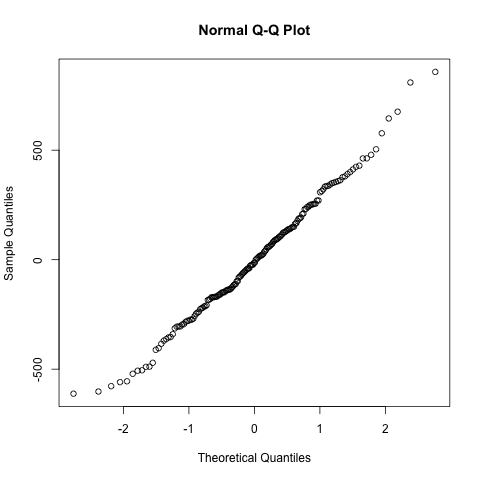

In [19]:
%%R -i df -o train_model_g -o train_anova_g
m <- lmer("total_licks ~ factor(day)*factor(CS)*factor(Chr2) + (1|mouse)", df)
train_model_g <-as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
train_anova_g <- anova(m)

In [20]:
train_model_g['Significance'] = train_model_g['Pr(>|t|)'].apply(check_significance)
train_anova_g['Significance'] = train_anova_g['Pr(>F)'].apply(check_significance)
supp_fig1_stats.update({'b_train_model_g': train_model_g,
                        'b_train_anova_g': train_anova_g})
display(train_anova_g, train_model_g)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),5.432280e+06,2.716140e+06,2,135.000001,26.825402,1.550850e-10,****
factor(CS),4.615194e+06,4.615194e+06,1,135.000001,45.581019,3.964062e-10,****
factor(Chr2),1.423454e+06,1.423454e+06,1,26.999997,14.058456,8.553946e-04,***
factor(day):factor(CS),1.383419e+06,6.917093e+05,2,135.000001,6.831525,1.492191e-03,**
factor(day):factor(Chr2),1.448683e+06,7.243416e+05,2,135.000001,7.153812,1.114283e-03,**
factor(CS):factor(Chr2),7.298038e+01,7.298038e+01,1,135.000001,0.000721,9.786212e-01,ns
factor(day):factor(CS):factor(Chr2),2.953049e+05,1.476524e+05,2,135.000001,1.458259,2.362818e-01,ns


,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),378.400000,151.522922,46.390033,2.497312,0.016123,*
factor(day)1,355.666667,116.190958,135.000001,3.061053,0.002662,**
factor(day)2,366.000000,116.190958,135.000001,3.149987,0.002011,**
factor(CS)+,534.400000,116.190958,135.000001,4.599325,0.000010,****
factor(Chr2)TRUE,456.385714,218.078734,46.390033,2.092757,0.041868,*
factor(day)1:factor(CS)+,-272.933333,164.318828,135.000001,-1.660999,0.099034,ns
factor(day)2:factor(CS)+,-356.400000,164.318828,135.000001,-2.168954,0.031838,*
factor(day)1:factor(Chr2)TRUE,356.119048,167.227352,135.000001,2.129550,0.035023,*
factor(day)2:factor(Chr2)TRUE,402.285714,167.227352,135.000001,2.405622,0.017500,*
factor(CS)+:factor(Chr2)TRUE,71.671429,167.227352,135.000001,0.428587,0.668907,ns


##### stats - glucose unlimited intake cummulative training licks stats

In [21]:
df = pd.concat({True: sg['total_licks'], False: cg['total_licks']}, names = ['Chr2']).rename("total_licks").reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
cumm_train_anova_g = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', dv = 'total_licks', subject = 'mouse', correction = True)
cumm_train_anova_g = cumm_train_anova_g.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_g['Significance'] = cumm_train_anova_g['p-value'].apply(check_significance)
stats_g_cumm = stats_g_cumm.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_g_cumm['Significance'] = stats_g_cumm['Corrected p-value'].apply(check_significance)


display(shapiro, levene, cumm_train_anova_g , stats_g_cumm)
supp_fig1_stats.update({'c_cumm_train_anova_g'   : cumm_train_anova_g,
                        'c_cumm_train_posthoc_g' : stats_g_cumm})

statistic   p-value
Chr2  CS                     
False +    0.944635  0.444228
      -    0.897411  0.086898
True  +    0.967637  0.843553
      -    0.979249  0.970224

,statistic,p-value
CS,,
+,2.380623,0.134489
-,3.117155,0.088780


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,6.579632e+07,1,27,6.579632e+07,14.058458,8.553937e-04,0.342401,NaN,***
1,CS,1.385826e+07,1,27,1.385826e+07,45.376332,3.118576e-07,0.626950,1.0,****
2,Interaction,2.189400e+02,1,27,2.189400e+02,0.000717,9.788364e-01,0.000027,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,4.408576,0.000706,0.001412,13,True,**
CS+ vs. CS- $AgRP^{TdTomato}$,5.164125,0.000144,0.000575,14,True,***
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,3.125205,0.004928,0.004928,27,False,**
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,4.311860,0.000314,0.000942,27,False,***


In [22]:
with pd.ExcelWriter(stat_save_loc/'supp_figure1.xlsx') as writer:  
    for k,v in supp_fig1_stats.items():
        v.to_excel(writer, sheet_name=k)

## get lick bursts

In [23]:
# compute lick burst number, average across days and format for model fitting
# glucose
_, bn = lick_microstructure(dft_test_g, 60)
burst_g_mn = bn.burst_num.unstack('CS').groupby(['Chr2','sex','mouse']).sum()
test_licks_g = (df_test_g.set_index('sex', append = True)
                         .total_licks
                         .unstack('CS')
                         .groupby(['Chr2','sex','mouse'])
                         .mean())
train_licks_g = (df_train_g.set_index('sex', append = True)
                           .total_licks
                           .unstack('CS')
                           .groupby(['Chr2','sex','mouse'])
                           .mean())
gb = pd.DataFrame({'tot' : burst_g_mn['+'] + burst_g_mn['-'],
                   'pref':  burst_g_mn['+']/(burst_g_mn['+'] + burst_g_mn['-']),
                   'csp_test'   : test_licks_g['+'],
                   'csm_test'   : test_licks_g['-'],
                   'csp_train'  : train_licks_g['+'],
                   'csm_train'  : train_licks_g['-']})
gb = gb.reset_index().dropna()
gb['stim'] = gb.Chr2.replace({True: r'$AgRP^{Chr2}$', False: r'$AgRP^{TdTomato}$'})
gb['cond_sex'] = gb.stim + ' ' + gb.sex

## Supplemental Figure 3 - validation of lick burst preference index

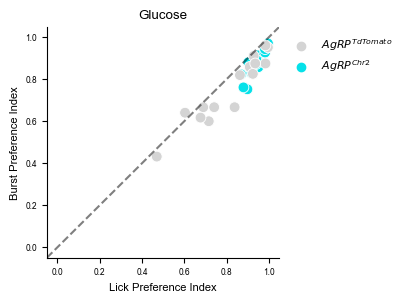

In [24]:
# create the subplot
fig, ax = plt.subplots(1,1, figsize = (3,3))

pref_g_burst = (bn.groupby(['Chr2', 'mouse','CS'])
                  .burst_num
                  .sum()
                  .unstack('CS')
                  .apply(lambda x: pd.Series({'pref': x["+"]/(x["+"] + x["-"]),
                                              'tot': x["+"] + x["-"]}), axis=1)
                  .reset_index()
               )
pref_g_burst['Condition'] = pref_g_burst.Chr2.replace({False: r"$AgRP^{TdTomato}$", True: r"$AgRP^{Chr2}$"})
pref_g_burst = pref_g_burst.set_index(["Condition","mouse"])

# plot preference index computed from bursts vs those computed from licks
pref_g_comb = pd.concat({'Lick Preference Index': pref_g.pref, 
                        'Burst Preference Index': pref_g_burst.pref}, axis=1)
sns.scatterplot(data = pref_g_comb.reset_index(), x = 'Lick Preference Index', 
                y = 'Burst Preference Index', hue = 'Condition', 
                hue_order = [r'$AgRP^{TdTomato}$', r'$AgRP^{Chr2}$'],
                s = 60, palette = [ctl_col, stim_col], ax = ax) 

# plot the diagonal
ax.plot([-.05,1.05],[-.05,1.05], ls = '--', c = 'k', alpha=.5)
ax.set_xlim([-.05,1.05])
ax.set_ylim([-.05,1.05])
ax.set_title('Glucose')

# format legend text
ax.legend(loc = 'upper left', bbox_to_anchor = (1,1), frameon = False, title = "")

for j in ax.get_xticklabels() + ax.get_yticklabels() :
        j.set_fontsize(6)


# remove bottom roww legends
sns.despine()


fig.savefig(fig_save_loc/'pdfs'/'supp_fig2_burst_pref_val.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'supp_fig2_burst_pref_val.svg', transparent=True, bbox_inches='tight')

#### stats

In [25]:
supp_fig3_stats = {}

##### stats - unlimited inntake lick burst preference vs lick preference stats

In [26]:
g_corr_stats = pd.DataFrame({'Signed Rank Test': st.wilcoxon(pref_g_burst.sort_index().pref.values, pref_g.sort_index().pref.values, axis=0),
                             'Spearman Correlation': st.spearmanr(pref_g_burst.sort_index().pref.values, pref_g.sort_index().pref.values, axis=0)},
                             index =  ('statistic', 'p-value')).T

g_corr_stats['Significance'] = g_corr_stats['p-value'].apply(check_significance)

display(g_corr_stats)
supp_fig3_stats.update({"a_lick_pref_burst_pref_corr_g": g_corr_stats})

,statistic,p-value,Significance
Signed Rank Test,7.000000,7.078052e-08,****
Spearman Correlation,0.907456,1.130116e-11,****


In [27]:
with pd.ExcelWriter(stat_save_loc/'supp_figure3.xlsx') as writer:  
    for k,v in supp_fig3_stats.items():
        v.to_excel(writer, sheet_name=k)

## Figure 2 - training v testing correlation

In [28]:
fig2_stats = {}

### model fitting

,VIF Factor,features
0,10.400683,Intercept
1,6.033268,C(Chr2)[T.True]
2,4.432433,csp_train
3,12.655538,C(Chr2)[T.True]:csp_train


,Result,Significance
Intercept,"β=0.2086; 95% CI [-0.0598, 0.477]; t(3430.0)=1...",ns
C(Chr2)[T.True],"β=1.6496; 95% CI [1.1803, 2.1188]; t(3430.0)=6...",****
csp_train,"β=0.0012; 95% CI [0.0009, 0.0015]; t(3430.0)=8...",****
C(Chr2)[T.True]:csp_train,"β=-0.0012; 95% CI [-0.0015, -0.0008]; t(3430.0...",****


,R2
Cox-Snell R2,0.979602


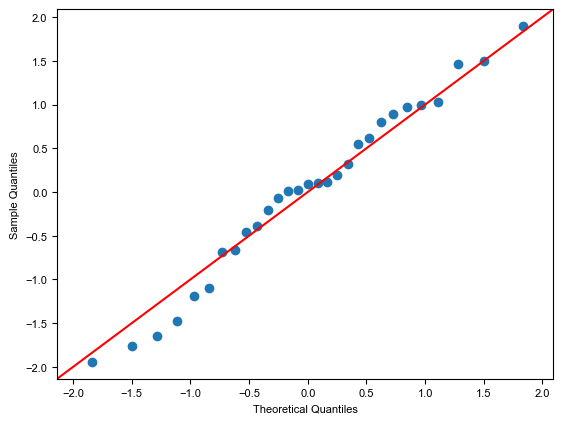

In [29]:
model_eq = 'pref ~ C(Chr2)*csp_train'
y, X = dmatrices(model_eq, gb, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
display(vif)

model_gb = smf.glm(model_eq, data = gb, 
                   family = sm.families.Binomial(), 
                   freq_weights = gb.tot).fit(use_t=True)

model_gb_summ = model_to_str(model_gb)
model_gb_pseudo_r2 = pd.DataFrame({"R2":model_gb.pseudo_rsquared()}, index=("Cox-Snell R2",))

display(model_gb_summ, model_gb_pseudo_r2)
sm.qqplot(model_gb.resid_deviance, fit=True, line='45');
fig2_stats.update({'c_train_v_test_glm_g': model_gb_summ,
                   'c_train_v_test_glm_g_r2': model_gb_pseudo_r2 })

#### separate models for control and stim 

,Result,Significance
Intercept,"β=1.8582; 95% CI [1.4732, 2.2432]; t(1556.0)=9...",****
csp_train,"β=0.0; 95% CI [-0.0002, 0.0002]; t(1556.0)=0.0...",ns


,R2
Cox-Snell R2,0.000003


,Result,Significance
Intercept,"β=0.2086; 95% CI [-0.0599, 0.4771]; t(1874.0)=...",ns
csp_train,"β=0.0012; 95% CI [0.0009, 0.0015]; t(1874.0)=8...",****


,R2
Cox-Snell R2,0.99644


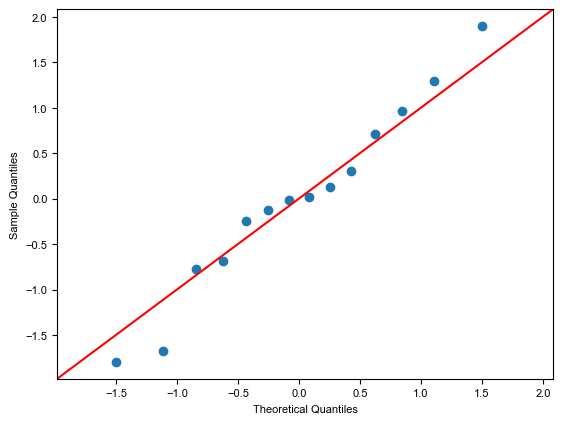

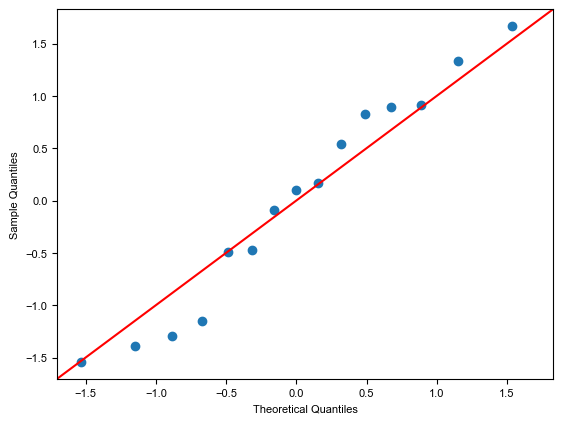

In [30]:
model_eq = 'pref ~ 1 + csp_train'

model_gb_stim = smf.glm(model_eq, data = gb.loc[gb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = gb.loc[gb.Chr2].tot).fit(use_t=True)
model_gb_stim_summ = model_to_str(model_gb_stim)
model_gb_stim_pseudo_r2 = pd.DataFrame({"R2": model_gb_stim.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_gb_stim.resid_deviance, fit=True, line='45');



model_gb_ctl = smf.glm(model_eq, data = gb.loc[~gb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = gb.loc[~gb.Chr2].tot).fit(use_t=True)
model_gb_ctl_summ = model_to_str(model_gb_ctl)
model_gb_ctl_pseudo_r2 = pd.DataFrame({"R2": model_gb_ctl.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_gb_ctl.resid_deviance, fit=True, line='45');


display(model_gb_stim_summ, model_gb_stim_pseudo_r2, model_gb_ctl_summ, model_gb_ctl_pseudo_r2)


fig2_stats.update({'c_train_v_test_glm_stim_g': model_gb_stim_summ,
                   'c_train_v_test_glm_stim_g_r2': model_gb_stim_pseudo_r2 ,
                   'c_train_v_test_glm_ctl_g': model_gb_ctl_summ,
                   'c_train_v_test_glm_ctl_g_r2': model_gb_ctl_pseudo_r2 })

### main plots - correlations

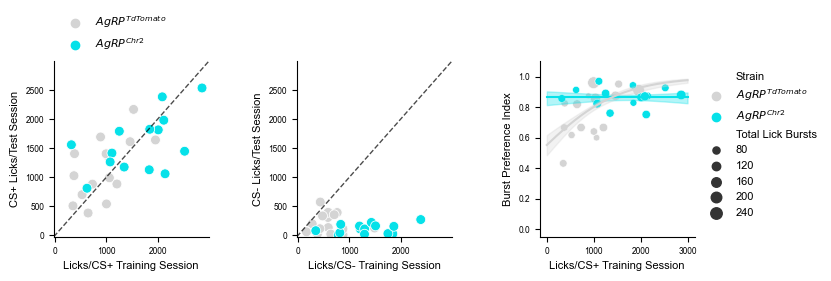

In [31]:
# create the subplot
fig, ax = plt.subplots(1, 3, figsize = (9,3.5))

# plot testing vs training licks for CS+ and CS-
sns.scatterplot(data =gb, x='csp_train', y= 'csp_test', hue='stim', 
                hue_order = [r'$AgRP^{TdTomato}$', r'$AgRP^{Chr2}$'],
                palette = [ ctl_col, stim_col], s=50, ax=ax[0]);
sns.scatterplot(data = gb, x='csm_train', y= 'csm_test', hue='stim', 
                hue_order = [r'$AgRP^{TdTomato}$', r'$AgRP^{Chr2}$'], 
                legend = False, palette = [ ctl_col, stim_col], s=50, ax=ax[1]);

ax[0].legend(loc = 'lower left', bbox_to_anchor = (0,1), frameon = False, title = "")

# determine common x and y limits for all plots
xlims = np.array([ ax[i].get_xlim() for i in range(2)])
ylims = np.array([ ax[i].get_ylim() for i in range(2)])
lims = np.concatenate((xlims, ylims), axis=0)
bnd = (lims[:,0].min(), lims[:,1].max())


# plot the diagonal for scatter plots
ax[0].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)
ax[1].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)

# plot preference vs training licks
sns.scatterplot(data = gb.rename(columns={'tot': 'Total Lick Bursts', 'stim': 'Strain'}),
                x='csp_train', y= 'pref', hue='Strain', legend = True, size='Total Lick Bursts',
                palette = [ ctl_col, stim_col], s=100, ax=ax[2]);
sns.move_legend(ax[2], loc='upper left', bbox_to_anchor = (1,1), frameon = False)


# get model predictions separately for stim and control mice
x = np.linspace(0,3000,1000) # test values
pred_stim_g = model_gb.get_prediction({'Chr2': [True]*x.size, 'csp_train': x})
pred_ctl_g = model_gb.get_prediction({'Chr2': [False]*x.size, 'csp_train': x})

# plot the model predictions
ax[2].plot(x, pred_stim_g.predicted_mean, c=stim_col)
ax[2].fill_between(x, pred_stim_g.conf_int()[:,0], 
                     pred_stim_g.conf_int()[:,1], 
                     alpha=.3, color = stim_col)
ax[2].plot(x,  pred_ctl_g.predicted_mean, c =ctl_col)
ax[2].fill_between(x, pred_ctl_g.conf_int()[:,0], 
                     pred_ctl_g.conf_int()[:,1], 
                     alpha=.3,color=ctl_col)



# label axes and set the axis limits
ax[0].set(ylabel = "CS+ Licks/Test Session", 
            xlabel = "Licks/CS+ Training Session",
            xlim  = bnd, ylim = bnd)
ax[1].set(ylabel = "CS- Licks/Test Session", 
            xlabel = "Licks/CS- Training Session",
            xlim  = bnd, ylim = bnd)

ax[2].set(xlabel = 'Licks/CS+ Training Session',
            ylabel = 'Burst Preference Index',
            ylim = (-.05,1.1))

for i in ax.flatten():
    for j in i.get_xticklabels() + i.get_yticklabels() :
        j.set_fontsize(6)
        
# format plots
sns.despine()
fig.tight_layout(pad = 4)

#save the figure
fig.savefig(fig_save_loc/'pdfs'/'fig2_corr.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig2_corr.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - glucose unlimited intake training vs testing licks correlation

In [32]:
r_csp, p_csp = st.pearsonr(gb['csp_train'], gb['csp_test'])
r_csm, p_csm = st.pearsonr(gb['csm_train'], gb['csm_test'])
corr_g_p = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csp, p_csp, check_significance(p_csp)]},
                      index = ('Pearson R', 'p-value', 'Significance')).T

corr_g_m = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csm, p_csm, check_significance(p_csm)]} ,
                      index = ('Pearson R', 'p-value', 'Significance')).T

display(corr_g_p, corr_g_m )
fig2_stats.update({'a_train_v_test_corr_g_csp': corr_g_p,
                   'b_train_v_test_corr_g_csm': corr_g_m,})

,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,0.636017,0.000209,***


,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,-0.159379,0.408902,ns


### sex differences

,Result,Significance
Intercept,"β=0.0033; 95% CI [-0.3869, 0.3936]; t(2052.0)=...",ns
C(Chr2)[T.True],"β=1.3197; 95% CI [-0.0072, 2.6466]; t(2052.0)=...",ns
csp_train,"β=0.0014; 95% CI [0.0011, 0.0018]; t(2052.0)=7...",****
C(Chr2)[T.True]:csp_train,"β=-0.0012; 95% CI [-0.0019, -0.0005]; t(2052.0...",***


,R2
Cox-Snell R2,0.992094


,Result,Significance
Intercept,"β=0.7489; 95% CI [0.2987, 1.1992]; t(1374.0)=3...",**
C(Chr2)[T.True],"β=1.5007; 95% CI [0.6447, 2.3566]; t(1374.0)=3...",***
csp_train,"β=0.0004; 95% CI [-0.0001, 0.0009]; t(1374.0)=...",ns
C(Chr2)[T.True]:csp_train,"β=-0.0008; 95% CI [-0.0017, 0.0001]; t(1374.0)...",ns


,R2
Cox-Snell R2,0.935906


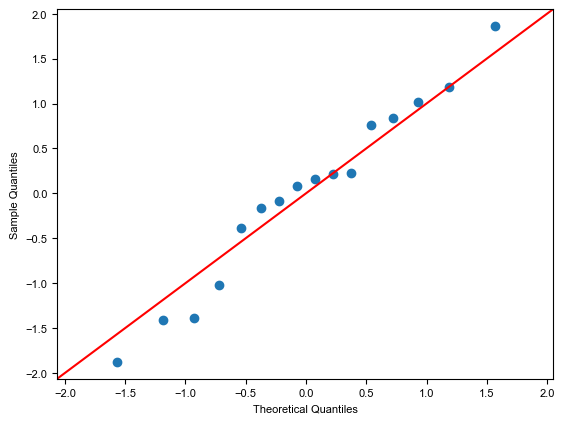

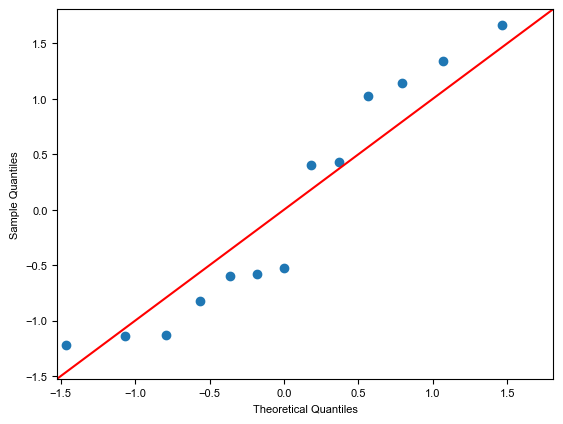

In [33]:
model_eq = 'pref ~ 1 + C(Chr2)*csp_train'

model_gm = smf.glm(model_eq, data = gb.loc[gb.sex=='M'], 
                    family = sm.families.Binomial(), 
                    freq_weights = gb.loc[gb.sex=='M'].tot).fit(use_t=True)
model_gm_summ = model_to_str(model_gm)
model_gm_pseudo_r2 = pd.DataFrame({"R2": model_gm.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_gm.resid_deviance, fit=True, line='45');



model_gf = smf.glm(model_eq, data = gb.loc[gb.sex=='F'], 
                    family = sm.families.Binomial(), 
                    freq_weights = gb.loc[gb.sex=='F'].tot).fit(use_t=True)
model_gf_summ = model_to_str(model_gf)
model_gf_pseudo_r2 = pd.DataFrame({"R2": model_gf.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_gf.resid_deviance, fit=True, line='45');


display(model_gm_summ, model_gm_pseudo_r2, model_gf_summ, model_gf_pseudo_r2)

fig2_stats.update({'train_v_test_glm_gm': model_gm_summ,
                   'train_v_test_glm_gm_r2': model_gm_pseudo_r2 ,
                   'train_v_test_glm_gf': model_gm_summ,
                   'train_v_test_glm_gf_r2': model_gm_pseudo_r2 })

### main plot - sex differences

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_65728/795944202.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


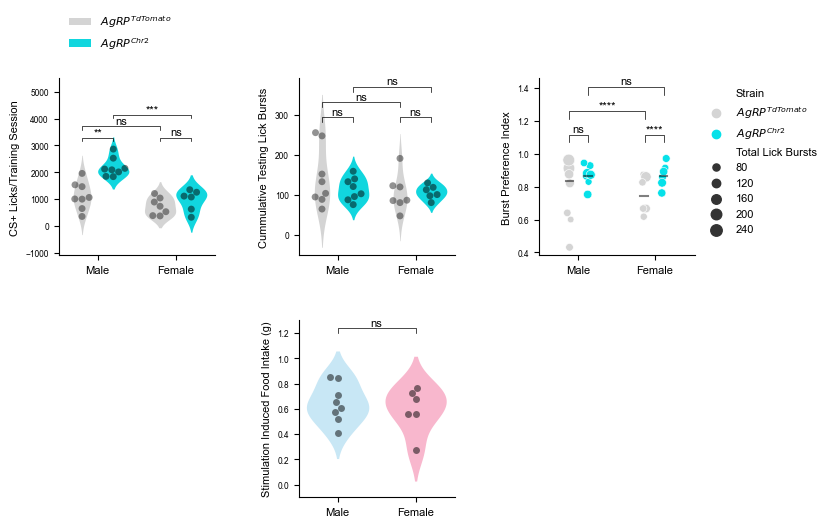

In [34]:
# create subplot
fig, ax = plt.subplots(2,3, figsize = (9,6))

# plot training licks split by strain and sex
_, train_sex_diff_stats = plot_sex_diff(gb, 'csp_train', ax=ax[0,0], palette = [ctl_col, stim_col], ylabel = "CS+ Licks/Training Session")
# plot total test licks by strain and sex
g, test_sex_diff_stats = plot_sex_diff(gb, 'tot', ax=ax[0,1], palette = [ctl_col, stim_col], ylabel = "Cummulative Testing Lick Bursts")
g.get_legend().remove()
# plot preference split by strain and sex
_, pref_sex_diff_stats = plot_sex_diff_pref(gb, ax=ax[0,2], palette = [ctl_col, stim_col])

# plot feeding data split by sex
feeding = (pd.read_csv(os.path.join(data_dir,"raw_data/normal_intake/opto_validation.csv"))
             .rename(columns = {'Mouse ': 'mouse'})
             .set_index('mouse'))
feeding['sex'] = df_test_g.loc[True,].sex.unstack(['day','CS']).iloc[:,0]
sns.swarmplot(data = feeding, x = 'sex', y = 'stim', color = 'k', order = ['M','F'],
              alpha = .5, ax = ax[1,1])
sns.violinplot(data = feeding, x = 'sex', y = 'stim',  order = ['M','F'],  
               palette = ['#C8E7F5', '#F8B7CD'], saturation = 1., 
               linewidth = 0, ax = ax[1,1])
ax[1,1].set_ylabel("Stimulation Induced Food Intake (g)")
ax[1,1].set_xlabel("")
ax[1,1].set_xticklabels(["Male", "Female"])

# compute stats
fint_sex_diff = st.ttest_ind(feeding.loc[feeding.sex=='F', 'stim'], 
                             feeding.loc[feeding.sex=='M', 'stim'], 
                             equal_var = False)
df = feeding.shape[0] - 2
fint_sex_diff = pd.DataFrame(list(fint_sex_diff) + [df], index = ['t', 'p-value', 'df'], columns = ['ttest']).T

# plot the stats
y = feeding.stim.max()
plot_significance(fint_sex_diff.loc['ttest','p-value'], ax[1,1], x1=0, x2=1, yy= 1.4*y, h=.05*y)

# adjust axis limits
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim(-.5,1.5)

for i in ax.flatten(): 
    for j in i.get_yticklabels():
        j.set_fontsize(6)
        
ax[0,0].set_ylim(-1100, 5500)
ax[1,1].set_ylim(-.1,1.3)
ax[1,0].axis('off')
ax[1,2].axis('off')

# format the plots
sns.despine()
fig.tight_layout(pad = 4)
fig.show()

# save the figure
fig.savefig(fig_save_loc/'pdfs'/'fig2_sex_diff.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig2_sex_diff.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - train licks

,Source,SS,DF,MS,F,p-unc,np2,Significance
0,sex,4.473879e+06,1.0,4.473879e+06,27.073443,0.000022,0.519909,****
1,Chr2,3.359952e+06,1.0,3.359952e+06,20.332576,0.000133,0.448520,***
2,sex * Chr2,1.242175e+06,1.0,1.242175e+06,7.516958,0.011127,0.231170,*
3,Residual,4.131243e+06,25.0,1.652497e+05,NaN,NaN,NaN,ns


,comparison,Chr2,t,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,1.784885,0.099583,13.0,NaN,0.189249,ns
1,Male vs Female,True,5.989366,0.000131,12.0,NaN,0.000524,***
2,Stim vs Control,NaN,1.079443,0.306444,11.0,F,0.306444,ns
3,Stim vs Control,NaN,4.803606,0.000396,14.0,M,0.001188,**


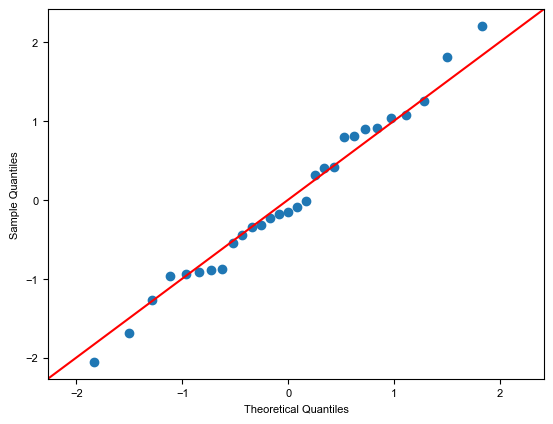

In [35]:
model = smf.ols('csp_train ~ C(sex, Sum)*C(Chr2, Sum)', data=gb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_train_sex_diff = pg.anova(data = gb, dv = 'csp_train', between = ['sex', 'Chr2'])
anova_train_sex_diff['Significance'] = anova_train_sex_diff['p-unc'].apply(check_significance)
train_sex_diff_stats['Significance'] = train_sex_diff_stats['Corrected p-value'].apply(check_significance)

display(anova_train_sex_diff,  train_sex_diff_stats)
fig2_stats.update({'d_anova_train_licks_sex_diff': anova_train_sex_diff,
                   'd_train_licks_sex_diff_stat': train_sex_diff_stats})

##### stats - total test bursts

,Source,SS,DF,MS,F,p-unc,np2,Significance
0,sex,3809.705370,1.0,3809.705370,1.700918,0.204049,0.063703,ns
1,Chr2,1553.914894,1.0,1553.914894,0.693776,0.412770,0.027002,ns
2,sex * Chr2,1593.227964,1.0,1593.227964,0.711328,0.407001,0.027666,ns
3,Residual,55994.857143,25.0,2239.794286,NaN,NaN,NaN,ns


,comparison,Chr2,t,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,1.214649,0.247963,13.0,NaN,0.680143,ns
1,Male vs Female,True,0.609559,0.553861,12.0,NaN,0.800960,ns
2,Stim vs Control,NaN,0.099753,0.923018,11.0,F,0.923018,ns
3,Stim vs Control,NaN,-1.021953,0.333110,14.0,M,0.703406,ns


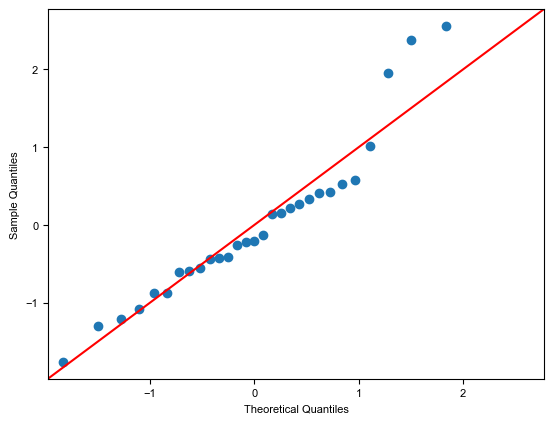

In [36]:
model = smf.ols('tot ~ C(sex, Sum)*C(Chr2, Sum)', data=gb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_test_sex_diff = pg.anova(data = gb, dv = 'tot', between = ['sex', 'Chr2'])
anova_test_sex_diff['Significance'] = anova_test_sex_diff['p-unc'].apply(check_significance)
test_sex_diff_stats['Significance'] = test_sex_diff_stats['Corrected p-value'].apply(check_significance)


display(anova_test_sex_diff,  test_sex_diff_stats)
fig2_stats.update({'e_anova_test_licks_sex_diff': anova_test_sex_diff,
                   'e_test_licks_sex_diff_stat': test_sex_diff_stats})

##### stats - burst preference indices

In [54]:
%%R -i gb -o pref_anova
pref_anova <- anova(glm('pref ~ factor(sex)*factor(Chr2)', data = gb, family = binomial, weights = tot), test = "Chisq")


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi),Significance
NULL,-2147483648,NaN,28,324.178772,NaN,ns
factor(sex),1,12.687048,27,311.491724,3.681970e-04,***
factor(Chr2),1,29.196423,26,282.295301,6.539984e-08,****
factor(sex):factor(Chr2),1,7.651014,25,274.644287,5.674043e-03,**


,comparison,Chr2,coef,t,CI,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,0.5341573428649018±0.11568208378795464,4.617460,"0.3074, 0.7609",3.884664e-06,1874.0,NaN,1.165395e-05,****
1,Male vs Female,True,0.010578871170580928±0.15062260749815748,0.070234,"-0.2846, 0.3058",9.440072e-01,1556.0,NaN,9.440072e-01,ns
2,Stim vs Control,NaN,0.7903582077295128±0.14288181639751613,5.531552,"0.5103, 1.0704",3.174096e-08,1376.0,F,1.269638e-07,****
3,Stim vs Control,NaN,0.2667797360351908±0.12511714887262215,2.132240,"0.0216, 0.512",3.298716e-02,2054.0,M,6.488616e-02,ns


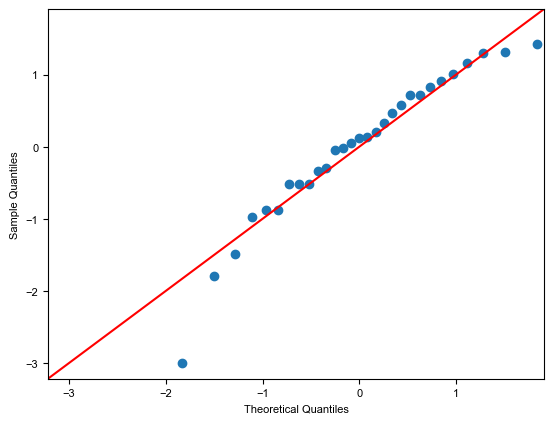

In [38]:
model = smf.glm('pref ~ 1 +  C(sex)*C(Chr2)', data = gb, freq_weights = gb.tot, family = sm.families.Binomial()).fit()
sm.qqplot(model.resid_deviance, fit=True, line='45');
pref_anova['Significance'] = pref_anova['Pr(>Chi)'].apply(check_significance)
pref_sex_diff_stats['Significance'] = pref_sex_diff_stats['Corrected p-value'].apply(check_significance)

display(pref_anova, pref_sex_diff_stats)

fig2_stats.update({'f_pref_sex_diff_anova': pref_anova,
                   'f_pref_sex_diff_stats': pref_sex_diff_stats})

##### stats - food intake

In [39]:
fint_sex_diff['Significance'] = fint_sex_diff['p-value'].apply(check_significance)
display(fint_sex_diff)
fig2_stats.update({"g_food_intake_sex_diff": fint_sex_diff})

,t,p-value,df,Significance
ttest,-0.576689,0.576951,12.0,ns


In [40]:
with pd.ExcelWriter(stat_save_loc/'figure2.xlsx') as writer:  
    for k,v in fig2_stats.items():
        v.to_excel(writer, sheet_name=k)

# limited intake, food deprived

## Figure 3 - limited intake

In [41]:
print("Controls: n = ",df_test_g_ltd.loc[False,].index.get_level_values('mouse').unique().size)
print("Stim: n = ", df_test_g_ltd.loc[True,].index.get_level_values('mouse').unique().size)

Controls: n =  19
Stim: n =  18


### main plots

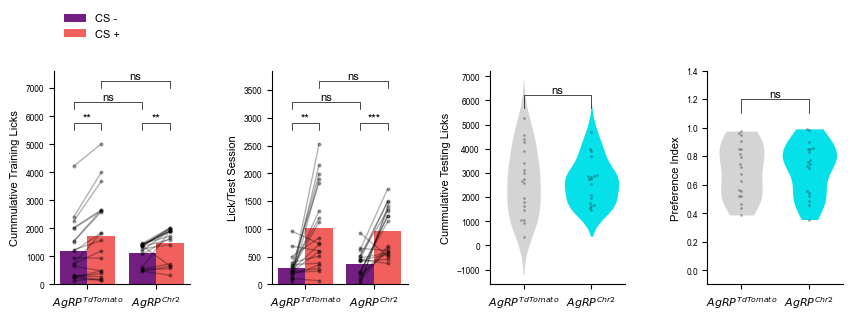

In [42]:
# create subplot
fig, ax = plt.subplots(1,4, figsize=(9,3.75))


# get cummulative training licks for stim and control mice
cumm = df_train_g_ltd.total_licks.groupby(['Chr2','mouse','CS']).sum()
sg = cumm.loc[True,].to_frame()
cg =  cumm.loc[False,].to_frame()

# get the average stim and control testing licks for CS+ vs CS- flavors
ltd_stim = average_test_data(df_test_g_ltd, Chr2=True)
ltd_ctl = average_test_data(df_test_g_ltd, Chr2=False)
_, stats_g_cumm_ltd= two_bottle_plot(sg,cg, ax = ax[0], ms=2, lw=1)

#reformat legends
ax[0].legend(ax[0].get_legend().legendHandles, ['CS -', 'CS +'], 
             loc = 'lower left', bbox_to_anchor = (0,1.1), frameon=False)

# label axes and add titles
ax[0].set_ylabel("Cummulative Training Licks", fontsize = 8)

# plot average CS+ and CS- testing licks for stim and control mice
_, stats_g_ltd = two_bottle_plot(ltd_stim, ltd_ctl, ax=ax[1], ms=2, lw=1);

# plot total licks
_, stats_cumm_ltd_g = cumm_test_licks_plot(df_test_g_ltd.loc[True,],df_test_g_ltd.loc[False,],
                     palette = [stim_col, ctl_col], ax = ax[2], ms=2)

# plot cummulative pref index for stim vs control
_, _, p_pref_ltd = two_bottle_pref_plot_vl(df_test_g_ltd.loc[True,], df_test_g_ltd.loc[False,] , 
                                        ax=ax[3], palette = [stim_col, ctl_col], ms=2);

# remove legends
ax[1].get_legend().remove()

for i in ax.flatten():
    for j in i.get_yticklabels() :
        j.set_fontsize(6)

# format plots
fig.tight_layout(pad=3.)
fig.savefig(fig_save_loc/'pdfs'/'fig3_ltd.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig3_ltd.svg', transparent=True, bbox_inches='tight')

#### stats

In [43]:
fig3_stats = {}

##### stats - glucose limited intake cummulative training licks

In [44]:
df = df_train_g_ltd.groupby(['Chr2','mouse','CS']).sum(numeric_only=True).reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
cumm_train_anova_g_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', 
                                        dv = 'total_licks', subject = 'mouse')
cumm_train_anova_g_ltd = cumm_train_anova_g_ltd.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_g_ltd['Significance'] = cumm_train_anova_g_ltd['p-value'].apply(check_significance)
stats_g_cumm_ltd = stats_g_cumm_ltd.rename(columns = {'statistic': 't', 
                                                      'pvalue': 'p-value', 
                                                      'pvalue_corr': 'Corrected p-value'})
stats_g_cumm_ltd['Significance'] = stats_g_cumm_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, cumm_train_anova_g_ltd, stats_g_cumm_ltd)
fig3_stats.update({'a_cumm_train_anova_g_ltd'   : cumm_train_anova_g_ltd,
                   'a_cumm_train_posthoc_g_ltd' : stats_g_cumm_ltd})

statistic   p-value
Chr2  CS                     
False +    0.902805  0.054698
      -    0.864988  0.011878
True  +    0.778797  0.000774
      -    0.739652  0.000240

,statistic,p-value
CS,,
+,10.968709,0.002159
-,6.888537,0.012772


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,4.648849e+05,1,35,4.648849e+05,0.261849,0.612066,0.007426,NaN,ns
1,CS,3.573245e+06,1,35,3.573245e+06,30.051644,0.000004,0.461966,1.0,****
2,Interaction,9.869608e+04,1,35,9.869608e+04,0.830052,0.368490,0.023166,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,3.715698,0.001718,0.005146,17,True,**
CS+ vs. CS- $AgRP^{TdTomato}$,4.071045,0.000717,0.002865,18,True,**
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,-0.638570,0.529097,0.778251,35,False,ns
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,-0.334715,0.740843,0.778251,35,False,ns


##### stats - glucose limited intake mean total licks during testing stats

In [45]:
df = df_test_g_ltd.groupby(['Chr2','mouse','CS']).mean(numeric_only=True).reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
test_anova_g_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2',
                                  dv = 'total_licks', subject = 'mouse')
test_anova_g_ltd = test_anova_g_ltd.rename(columns = {'p-unc': 'p-value'})
test_anova_g_ltd['Significance'] = test_anova_g_ltd['p-value'].apply(check_significance)
stats_g_ltd = stats_g_ltd.rename(columns = {'statistic': 't', 
                                            'pvalue': 'p-value', 
                                            'pvalue_corr': 'Corrected p-value'})
stats_g_ltd['Significance'] = stats_g_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, test_anova_g_ltd, stats_g_ltd)
fig3_stats.update({'b_test_anova_g_ltd'   : test_anova_g_ltd,
                   'b_test_posthoc_g_ltd' : stats_g_ltd})

statistic   p-value
Chr2  CS                     
False +    0.912920  0.083764
      -    0.818898  0.002179
True  +    0.880429  0.026541
      -    0.949447  0.416411

,statistic,p-value
CS,,
+,1.892540,0.177656
-,1.221046,0.276694


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,3.576368e+02,1,35,3.576368e+02,0.001959,0.964951,0.000056,NaN,ns
1,CS,8.110824e+06,1,35,8.110824e+06,32.727068,0.000002,0.483220,1.0,****
2,Interaction,6.215563e+04,1,35,6.215563e+04,0.250797,0.619649,0.007115,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,4.710151,0.000202,0.000807,17,True,***
CS+ vs. CS- $AgRP^{TdTomato}$,3.782804,0.001363,0.004082,18,True,**
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,-0.268991,0.789785,0.789785,35,False,ns
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,0.813413,0.421638,0.665497,35,False,ns


##### stats - limited intake cummulative testing licks

In [46]:
res_g = pd.DataFrame({"t": [stats_cumm_ltd_g[0]], 
                      "df": [stats_cumm_ltd_g[2]],
                      "p-value": [stats_cumm_ltd_g[1]], 
                      "Significance": check_significance(stats_cumm_ltd_g[1])
                     }, index = ['ttest'])

print("glucose")
display(res_g)

fig3_stats.update({"c_ttest_stim_v_ctl_tot_g_ltd": res_g})

glucose


,t,df,p-value,Significance
ttest,0.044725,35,0.964608,ns


##### stats - stim v control pref comparison

In [47]:
res_g = pd.DataFrame({"U": [p_pref_ltd[0]], 
                      "p-value": [p_pref_ltd[1]],
                      "Significance": check_significance(p_pref_ltd[1])
                     }, index = ['mann whitney u test'])
print("glucose")
display(res_g)

fig3_stats.update({"d_rsum_stim_v_ctl_pref_g_ltd": res_g})

glucose


,U,p-value,Significance
mann whitney u test,178.0,0.843425,ns


### sex differences

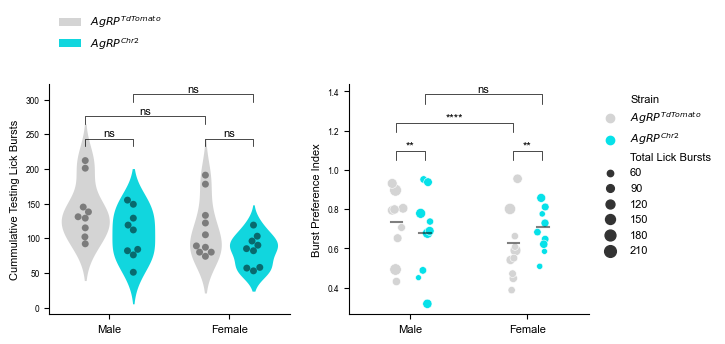

In [48]:
#get burst numbers for burst preference indices
bn_ltd = lick_microstructure(dft_test_g_ltd, 60)[1]

#get preferences
pref_ltd =  bn_ltd.groupby(['Chr2', 'sex', 'mouse', 'CS']).burst_num.sum().unstack('CS')
pref_ltd =  pd.concat({'tot': pref_ltd.sum(axis=1), 'pref': pref_ltd['+']/pref_ltd.sum(axis=1)}, axis=1).reset_index()

fig, ax = plt.subplots(1,2, figsize = (7.5,3.75))

_, test_sex_diff_ltd_stats = plot_sex_diff(pref_ltd, 'tot', ax=ax[0], palette = [ctl_col, stim_col], ylabel='Cummulative Testing Lick Bursts')
ax[0].set_xlim(-.5, 1.5)
_, pref_sex_diff_ltd_stats = plot_sex_diff_pref(pref_ltd, ax=ax[1], palette = [ctl_col, stim_col] )

sns.despine()
for i in ax.flatten():
    for j in i.get_yticklabels() :
            j.set_fontsize(6)
fig.tight_layout(pad=2.)

fig.savefig(fig_save_loc/'pdfs'/'supp_fig3_sex_diff_ltd_g.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'supp_fig3_sex_diff_ltd_g.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - total lick bursts

,Source,SS,DF,MS,F,p-unc,np2,Significance
0,sex,5890.725446,1.0,5890.725446,4.480223,0.041916,0.119536,*
1,Chr2,9904.935972,1.0,9904.935972,7.533252,0.009723,0.185854,**
2,sex * Chr2,19.111396,1.0,19.111396,0.014535,0.904769,0.000440,ns
3,Residual,43389.344444,33.0,1314.828620,NaN,NaN,NaN,ns


,comparison,Chr2,t,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,1.398847,0.179989,17.0,NaN,0.215536,ns
1,Male vs Female,True,1.699966,0.111804,16.0,NaN,0.215536,ns
2,Stim vs Control,NaN,-2.054684,0.058884,17.0,F,0.215536,ns
3,Stim vs Control,NaN,-1.895304,0.076683,16.0,M,0.215536,ns


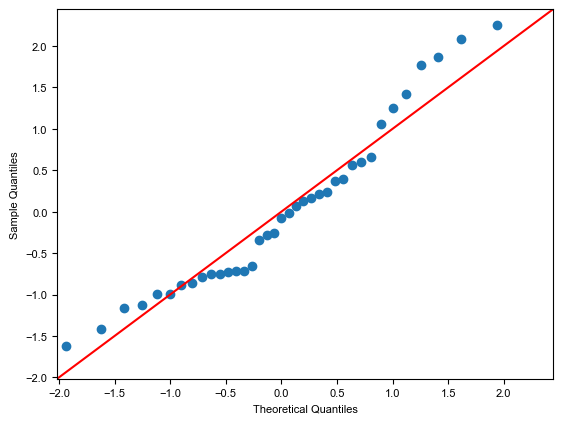

In [49]:
model = smf.ols('tot ~ C(sex, Sum)*C(Chr2, Sum)', data=pref_ltd).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_test_sex_diff_ltd = pg.anova(data = pref_ltd, dv = 'tot', between = ['sex', 'Chr2'])
anova_test_sex_diff_ltd['Significance'] = anova_test_sex_diff_ltd['p-unc'].apply(check_significance)
test_sex_diff_ltd_stats['Significance'] = test_sex_diff_ltd_stats['Corrected p-value'].apply(check_significance)


display(anova_test_sex_diff_ltd,  test_sex_diff_ltd_stats)
fig3_stats.update({'e_anova_test_licks_sex_diff_ltd': anova_test_sex_diff_ltd,
                   'e_test_licks_sex_diff_ltd_stat': test_sex_diff_ltd_stats})

##### stats - burst preference index

In [50]:
%%R -i pref_ltd -o pref_anova_ltd
pref_anova_ltd <- anova(glm('pref ~ factor(sex)*factor(Chr2)', data = pref_ltd, family = binomial, weights = tot), test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi),Significance
NULL,-2147483648,NaN,36,593.368925,NaN,ns
factor(sex),1,10.873501,35,582.495424,0.000975,***
factor(Chr2),1,0.082127,34,582.413297,0.774436,ns
factor(sex):factor(Chr2),1,20.155632,33,562.257665,0.000007,****


,comparison,Chr2,coef,t,CI,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,0.47480360070212047±0.0882843953046905,5.378115,"0.3018, 0.6478",7.526988e-08,2402,NaN,3.010795e-07,****
1,Male vs Female,True,-0.14312920278082647±0.10612878666867749,-1.348637,"-0.3511, 0.0649",1.774536e-01,1698,NaN,1.774536e-01,ns
2,Stim vs Control,NaN,0.348832673238926±0.10127332442526865,3.444467,"0.1503, 0.5473",5.721854e-04,1880,F,1.715574e-03,**
3,Stim vs Control,NaN,-0.26910013024402024±0.0938145381800434,-2.868427,"-0.453, -0.0852",4.125187e-03,2220,M,8.233357e-03,**


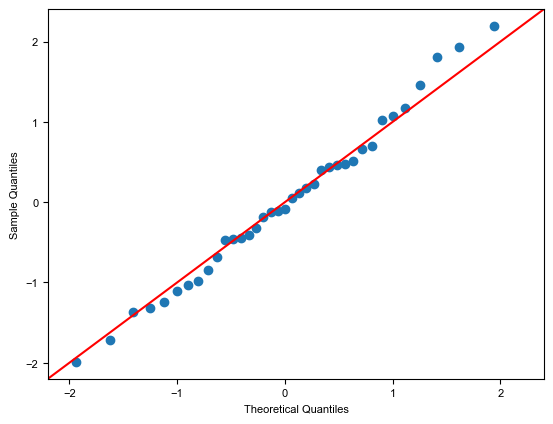

In [51]:
model = smf.glm('pref ~ 1 +  C(sex)*C(Chr2)', data = pref_ltd, freq_weights = pref_ltd.tot, family = sm.families.Binomial()).fit()
sm.qqplot(model.resid_deviance, fit=True, line='45');
pref_anova_ltd['Significance'] = pref_anova_ltd['Pr(>Chi)'].apply(check_significance)
pref_sex_diff_ltd_stats['Significance'] = pref_sex_diff_ltd_stats['Corrected p-value'].apply(check_significance)


display(pref_anova_ltd, pref_sex_diff_ltd_stats)

fig3_stats.update({'f_pref_sex_diff_anova_ltd': pref_anova_ltd,
                   'f_pref_sex_diff_stats_ltd': pref_sex_diff_ltd_stats})

In [52]:
with pd.ExcelWriter(stat_save_loc/'figure3.xlsx') as writer:  
    for k,v in fig3_stats.items():
        v.to_excel(writer, sheet_name=k)